# Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
import matplotlib.pyplot as plt

# EDA

In [2]:
df = pd.read_csv('compas_people.csv')
df

,id,name,first,last,sex,race,dob,age,age_cat,juv_fel_count,...,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,is_violent_recid,num_vr_cases,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc
0,1,miguel hernandez,miguel,hernandez,Male,Other,1947-04-18 00:00:00.000000,69,Greater than 45,0,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2,michael ryan,michael,ryan,Male,Caucasian,1985-02-06 00:00:00.000000,31,25 - 45,0,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
2,3,kevon dixon,kevon,dixon,Male,African-American,1982-01-22 00:00:00.000000,34,25 - 45,0,...,2013-07-05 00:00:00.000000,Felony Battery (Dom Strang),NaN,NaN,1,NaN,13009779CF10A,(F3),2013-07-05 00:00:00.000000,Felony Battery (Dom Strang)
3,4,ed philo,ed,philo,Male,African-American,1991-05-14 00:00:00.000000,24,Less than 25,0,...,2013-06-16 00:00:00.000000,Driving Under The Influence,2013-06-16 09:05:47.000000,2013-06-16 07:18:55.000000,0,NaN,NaN,NaN,NaN,NaN
4,5,marcu brown,marcu,brown,Male,African-American,1993-01-21 00:00:00.000000,23,Less than 25,0,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11752,11753,patrick hamilton,patrick,hamilton,Male,Other,1968-05-02 00:00:00.000000,47,Greater than 45,0,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
11753,11754,raymond hernandez,raymond,hernandez,Male,Caucasian,1993-06-24 00:00:00.000000,22,Less than 25,0,...,2014-10-11 00:00:00.000000,Driving License Suspended,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
11754,11755,dieuseul pierre-gilles,dieuseul,pierre-gilles,Male,Other,1981-01-24 00:00:00.000000,35,25 - 45,0,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
11755,11756,scott lomagistro,scott,lomagistro,Male,Caucasian,1986-12-04 00:00:00.000000,29,25 - 45,0,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11757 entries, 0 to 11756
Data columns (total 41 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       11757 non-null  int64  
 1   name                     11757 non-null  object 
 2   first                    11757 non-null  object 
 3   last                     11757 non-null  object 
 4   sex                      11757 non-null  object 
 5   race                     11757 non-null  object 
 6   dob                      11757 non-null  object 
 7   age                      11757 non-null  int64  
 8   age_cat                  11757 non-null  object 
 9   juv_fel_count            11757 non-null  int64  
 10  juv_misd_count           11757 non-null  int64  
 11  juv_other_count          11757 non-null  int64  
 12  compas_screening_date    11757 non-null  object 
 13  decile_score             11757 non-null  int64  
 14  score_text            

Okay, not too bad. We're gonna get rid of a lot of categories, though: mostly ones that assume that recidivism has already happened along with some that are unique, like `name` and `c_case_number`.

In [4]:
df = df.drop(['name', 'first', 'last', 
              'score_text', 'violent_recid', 'c_case_number', 
              'c_offense_date', 'c_charge_desc', 'r_case_number', 
              'r_charge_degree', 'r_days_from_arrest', 'r_offense_date', 
              'r_charge_desc', 'r_jail_in', 'r_jail_out', 
              'is_violent_recid', 'num_vr_cases', 'vr_case_number', 
              'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc',
              'c_arrest_date', 'dob', 'days_b_screening_arrest',
              'c_days_from_compas', 'id', 'compas_screening_date',
              'num_r_cases'], axis=1)

Next we're gonna consolidate `jail-in` and `jail-out` to `jail-time` so we only have to deal with a duration.

In [5]:
df['jail_time'] = (pd.to_datetime(df.c_jail_out) - pd.to_datetime(df.c_jail_in)).astype("timedelta64[s]")
df.jail_time.fillna(0, inplace=True)
df.drop(['c_jail_in', 'c_jail_out'], axis=1, inplace=True)

Okay, so, there's a couple different charge degrees missing values - we're gonna fill those in with the most common value for that column.

In [6]:
df.c_charge_degree.value_counts()

(F3)     5913
(M1)     2831
(F2)      953
(M2)      857
(F1)      221
(F7)      128
(MO3)      83
(F6)       10
(NI0)       8
(F5)        7
(X)         1
(CT)        1
(TCX)       1
(CO3)       1
Name: c_charge_degree, dtype: int64

In [7]:
df.c_charge_degree.fillna('(F3)', inplace=True)

There's a number of entries that have a recidivism score of -1 - unfortunately, without a usable truth value, those entries aren't useful to us.

In [8]:
df = df[df.is_recid != -1]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11038 entries, 0 to 11756
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sex              11038 non-null  object 
 1   race             11038 non-null  object 
 2   age              11038 non-null  int64  
 3   age_cat          11038 non-null  object 
 4   juv_fel_count    11038 non-null  int64  
 5   juv_misd_count   11038 non-null  int64  
 6   juv_other_count  11038 non-null  int64  
 7   decile_score     11038 non-null  int64  
 8   priors_count     11038 non-null  int64  
 9   c_charge_degree  11038 non-null  object 
 10  is_recid         11038 non-null  int64  
 11  jail_time        11038 non-null  float64
dtypes: float64(1), int64(7), object(4)
memory usage: 1.1+ MB


Much better. Now we're gonna split off the data that needs to be scaled and the data that needs to be encoded into a one-hot, do those transformations, then put them back together.

In [10]:
needs_scaling = df.drop(['sex', 'race', 'age_cat', 'c_charge_degree', 'is_recid'], axis=1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(needs_scaling)

needs_encoding = df[['sex', 'age_cat', 'c_charge_degree']]

enc = OneHotEncoder(sparse=False)
one_hot_data = enc.fit_transform(needs_encoding)

transformed_data = np.concatenate((scaled_data, one_hot_data), axis=1)

This next bit is pretty straightforward: split the data into train/test/validation sets. The only slightly unusual thing we're going to do is to create new DataFrames to store the train/test/validation data so that we can come back and do some analysis at the end.

In [11]:
y = df['is_recid'].values
x = transformed_data

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3)

train_df = pd.DataFrame([])
combo_df = pd.DataFrame([])
test_df = pd.DataFrame([])
valid_df = pd.DataFrame([])

for train_index, combo_index in sss.split(x, y):
    train_x, combo_x = x[train_index], x[combo_index]
    train_y, combo_y = y[train_index], y[combo_index]
    train_df = train_df.append(df.iloc[train_index])
    combo_df = combo_df.append(df.iloc[combo_index])
    
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5)

for test_index, valid_index in sss.split(combo_x, combo_y):
    test_x, valid_x = combo_x[test_index], combo_x[valid_index]
    test_y, valid_y = combo_y[test_index], combo_y[valid_index]
    test_df = test_df.append(combo_df.iloc[test_index])
    valid_df = valid_df.append(combo_df.iloc[valid_index])

Last but not least we define a couple helper methods.

In [12]:
best_model = {'acc': 0}

# Tracks model with highest accuracy
def update_best_model(acc, name, model, params):
    if (acc > best_model['acc']):
        best_model['acc'] = acc
        best_model['name'] = name
        best_model['model'] = model
        best_model['params'] = params

# Performs a grid search on a passed-in classifier
def run_grid_search(folds, params, clf, name):
    gscv = GridSearchCV(clf, params, cv=folds)
    gscv.fit(train_x, train_y)
    acc = accuracy_score(test_y, gscv.predict(test_x))
    update_best_model(acc, name, gscv, gscv.best_params_)

# Algorithm Testing

Now we're gonna perform a grid search on several different algorithms: KNN, Decision Trees, Random Forest, Logistic Regression, and DNN. The accuracy score for each algorithm will be compared against each other and the model with the highest accuracy will be retained so we can test it against the validation dataset.

## KNN

In [13]:
folds = 10
params = {'n_neighbors': list(range(3, 16))}

run_grid_search(folds, params, KNeighborsClassifier(), 'KNN')

## Trees

### Decision Tree

In [14]:
folds = 10
params = {'criterion': ('entropy', 'gini'),
         'max_depth': [2, 3, 4, 5, 6, 7, 8]}

run_grid_search(folds, params, DecisionTreeClassifier(), 'Decision Tree')

### Random Forest

In [15]:
folds = 10
params = {'criterion': ('entropy', 'gini'),
         'max_depth': [2, 3, 4, 5, 6, 7, 8],
         'n_estimators': [10, 20, 30, 40]}

run_grid_search(folds, params, RandomForestClassifier(), 'Random Forest')

## Logistic Regression

In [16]:
folds = 10
params = {'penalty': ['l1', 'l2'],
             'C': [1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100, 1000, 10000]}

run_grid_search(folds, params, LogisticRegression(solver='liblinear'), 'Logistic Regression')

## DNN

WARNING: 
- Running the following code locally will write run logs to your machine 
- These files *do not* overwrite themselves. Run `!rm -rf ./logs` to delete old runs.
- The `--logdir` argument for Tensorboard doesn't work great - this is a known issue. Instead of navigating to the provided directory, Tensorboard will (at least, on Windows) display all the logs in the first folder it finds (using a top-down search) that has logs.

In [17]:
train_x = tf.dtypes.cast(train_x, tf.float64)
test_x = tf.dtypes.cast(test_x, tf.float64)
valid_x = tf.dtypes.cast(valid_x, tf.float64)

train_y = tf.dtypes.cast(train_y, tf.int64)
test_y = tf.dtypes.cast(test_y, tf.int64)
valid_y = tf.dtypes.cast(valid_y, tf.int64)

In [18]:
%load_ext tensorboard

In [19]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([40, 80, 120]))
HP_NUM_LAYERS = hp.HParam('num_layers', hp.Discrete([1, 2, 3]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd', 'rmsprop']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_NUM_LAYERS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

### Notes

- Adding loss weights doesn't really affect accuracy but *can* massively decrease loss, for some reason. [0.2, 3] reduces loss from ~0.5 all the way down to 0.1-0.12 range
- Deriving the loss weights from the dataset itself doesn't seem to make much of a difference
- Messing around with the loss function doesn't really do much

In [20]:
def train_test_model(hparams):

  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Flatten())

  for i in range(hparams[HP_NUM_LAYERS]):
        model.add(tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation=tf.nn.relu))
        
  model.add(tf.keras.layers.Dropout(hparams[HP_DROPOUT]))
  model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax))

  model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy'],
#       loss_weights=[0.2,3],
  )
    
  model.fit(train_x, train_y, epochs=20) 
  _, accuracy = model.evaluate(test_x, test_y)
    
  update_best_model(accuracy, 'DNN', model, hparams)

  return accuracy

In [21]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [22]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
        for num_layers in HP_NUM_LAYERS.domain.values:
          hparams = {
              HP_NUM_UNITS: num_units,
              HP_DROPOUT: dropout_rate,
              HP_OPTIMIZER: optimizer,
              HP_NUM_LAYERS: num_layers,
          }
          run_name = "run-%d" % session_num
          print('--- Starting trial: %s' % run_name)
          print({h.name: hparams[h] for h in hparams})
          run('logs/hparam_tuning/' + run_name, hparams)
          session_num += 1

--- Starting trial: run-0
{'num_units': 40, 'dropout': 0.1, 'optimizer': 'adam', 'num_layers': 1}
Epoch 1/20
242/242 [==============================] - 1s 1ms/step - loss: 0.6124 - accuracy: 0.6608
Epoch 2/20
242/242 [==============================] - 1s 3ms/step - loss: 0.5800 - accuracy: 0.6951
Epoch 3/20
242/242 [==============================] - 0s 2ms/step - loss: 0.5769 - accuracy: 0.7026
Epoch 4/20
242/242 [==============================] - 0s 1ms/step - loss: 0.5748 - accuracy: 0.7024
Epoch 5/20
242/242 [==============================] - 1s 2ms/step - loss: 0.5745 - accuracy: 0.6987
Epoch 6/20
242/242 [==============================] - 0s 2ms/step - loss: 0.5731 - accuracy: 0.7040
Epoch 7/20
242/242 [==============================] - 0s 1ms/step - loss: 0.5705 - accuracy: 0.7045
Epoch 8/20
242/242 [==============================] - 0s 2ms/step - loss: 0.5716 - accuracy: 0.7020
Epoch 9/20
242/242 [==============================] - 0s 2ms/step - loss: 0.5699 - accuracy: 0.7024
Ep

In [23]:
%tensorboard --logdir logs/hparam_tuning --host localhost

Reusing TensorBoard on port 6006 (pid 13816), started 3 days, 19:02:53 ago. (Use '!kill 13816' to kill it.)

# Results

In [24]:
print('Best Model:', best_model['name'], '\nAccuracy:', best_model['acc']) 

if (best_model['name'] == 'DNN'):
    print('Parameters:', best_model['params'].values())
else:
    print('Parameters:', best_model['params'])

Best Model: DNN 
Accuracy: 0.716183602809906
Parameters: dict_values([80, 0.2, 'rmsprop', 1])


Now, let's test our best model against our validation set and see how it does.

In [25]:
prediction = best_model['model'].predict(valid_x)
if (best_model['name'] == 'DNN'):
    prediction = np.argmax(prediction, axis=1)
    _, valid_acc = best_model['model'].evaluate(valid_x, valid_y)
else:
    valid_acc = accuracy_score(valid_y, prediction)

print("Accuracy of best model on validation set:", valid_acc)

52/52 [==============================] - 0s 843us/step - loss: 0.5527 - accuracy: 0.7289
Accuracy of best model on validation set: 0.7288647294044495


## Racism Analysis

Last but not least, let's check out how racist our model is!

In [26]:
# Method to get different sets of data based on recidivism value
def get_diff_dict(column):
    predict_df = valid_df.copy(deep=True)   
    predict_df[column] = prediction

    yes_predict_df = predict_df[predict_df[column] == 1]
    yes_valid_df = valid_df[valid_df[column] == 1]

    no_predict_df = predict_df[predict_df[column] == 0]
    no_valid_df = valid_df[valid_df[column] == 0]

    return {'Validation Set': valid_df, 'Prediction Set': predict_df,
              'Validation where Recidivism=True': yes_valid_df, 'Prediction where Recidivism=True': yes_predict_df,
              'Validation where Recidivism=False': no_valid_df, 'Prediction where Recidivism=False': no_predict_df}
    
    
diff_dict = get_diff_dict('is_recid')
diff_values = list(diff_dict.values())

<function matplotlib.pyplot.show(close=None, block=None)>

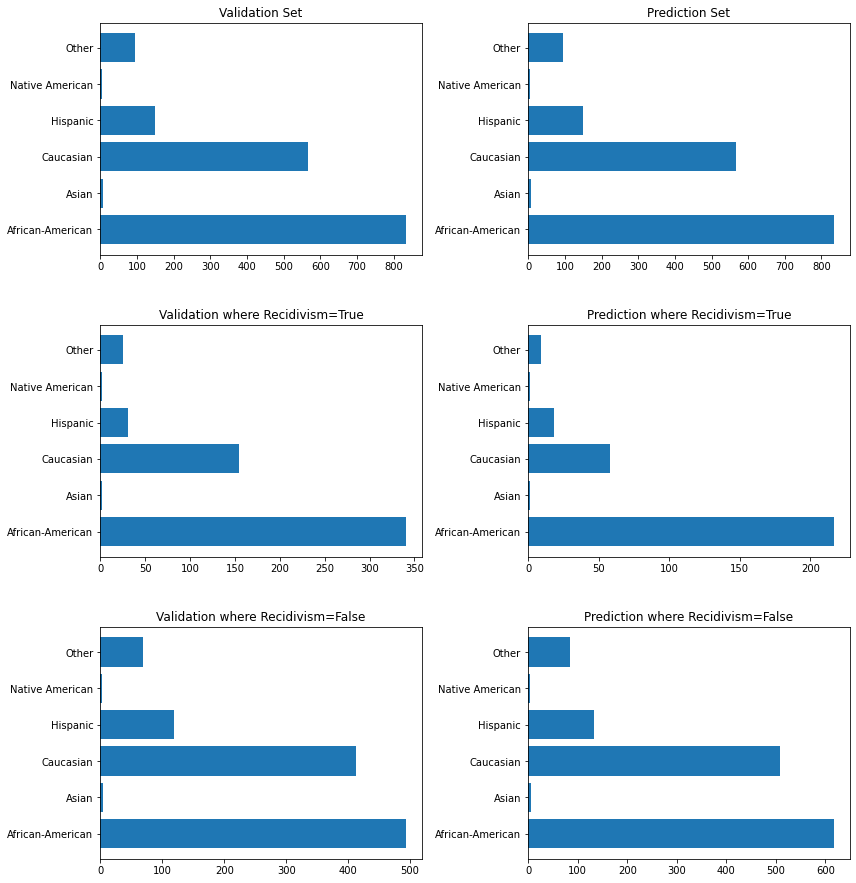

In [27]:
fig = plt.figure(figsize=(12, 8))
i = 1
for k, v in diff_dict.items():
    ax = fig.add_subplot(3,2,i)
    ax.barh(v.sort_values('race')['race'].unique(), v.sort_values('race')['race'].value_counts(sort=False))
    ax.set_title(k)
    i += 1
fig.tight_layout()
plt.subplots_adjust(top=1.5)
plt.show

In [28]:
pd.options.display.float_format = '{:.2%}'.format
def compare_ethnic_spread(base_df, hyp_df):
    base_ethnicity_spread = base_df['race'].value_counts(normalize=True)
    hyp_ethnicity_spread = hyp_df['race'].value_counts(normalize=True)

    
    print(
'''          ACTUAL
{}\n--------------------------
         PREDICTED
{}\n--------------------------
         DIFFERENCE'''.format(base_ethnicity_spread, hyp_ethnicity_spread))
    
    diff = dict()
    for race in hyp_df['race'].unique():
        diff[race] = hyp_ethnicity_spread[race] - base_ethnicity_spread[race]
        
    print("\n".join("{:>17}  {:>6.2%}".format(k, v) for k, v in diff.items()))

In [29]:
print("        UNFILTERED\n")
compare_ethnic_spread(diff_values[0], diff_values[1])

        UNFILTERED

          ACTUAL
African-American   50.42%
Caucasian          34.18%
Hispanic            9.06%
Other               5.68%
Asian               0.42%
Native American     0.24%
Name: race, dtype: float64
--------------------------
         PREDICTED
African-American   50.42%
Caucasian          34.18%
Hispanic            9.06%
Other               5.68%
Asian               0.42%
Native American     0.24%
Name: race, dtype: float64
--------------------------
         DIFFERENCE
 African-American   0.00%
        Caucasian   0.00%
            Other   0.00%
         Hispanic   0.00%
            Asian   0.00%
  Native American   0.00%


In [30]:
print("    RECIDIVISM == TRUE\n")
compare_ethnic_spread(diff_values[2], diff_values[3])

    RECIDIVISM == TRUE

          ACTUAL
African-American   61.44%
Caucasian          27.75%
Hispanic            5.59%
Other               4.50%
Asian               0.36%
Native American     0.36%
Name: race, dtype: float64
--------------------------
         PREDICTED
African-American   71.38%
Caucasian          19.08%
Hispanic            5.92%
Other               2.96%
Asian               0.33%
Native American     0.33%
Name: race, dtype: float64
--------------------------
         DIFFERENCE
 African-American   9.94%
        Caucasian  -8.67%
            Other  -1.54%
         Hispanic   0.34%
            Asian  -0.03%
  Native American  -0.03%


In [31]:
print("   RECIDIVISM == FALSE\n")
compare_ethnic_spread(diff_values[4], diff_values[5])

   RECIDIVISM == FALSE

          ACTUAL
African-American   44.87%
Caucasian          37.42%
Hispanic           10.81%
Other               6.27%
Asian               0.45%
Native American     0.18%
Name: race, dtype: float64
--------------------------
         PREDICTED
African-American   45.71%
Caucasian          37.57%
Hispanic            9.76%
Other               6.29%
Asian               0.44%
Native American     0.22%
Name: race, dtype: float64
--------------------------
         DIFFERENCE
 African-American   0.84%
        Caucasian   0.15%
            Other   0.02%
         Hispanic  -1.05%
            Asian  -0.01%
  Native American   0.04%
